<a href="https://colab.research.google.com/github/jayarnim/project-Comparative_Analysis_of_Changes_in_Influence_of_Market_Demand_Determinants/blob/main/code/03_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (11.8 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121666 files and direc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/2023-2_MachineLearning/Project/

Mounted at /content/drive
/content/drive/MyDrive/2023-2_MachineLearning/Project


In [ ]:
from common import data, variable, sector
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge, SGDRegressor

In [ ]:
# 경고 무시
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 및 마이너스 기호 깨짐 조정
plt.rc('font', family = 'NanumGothic')
plt.rc('axes', unicode_minus = False)

# 이상치 처리

## 변수별 이상치 분포 탐색

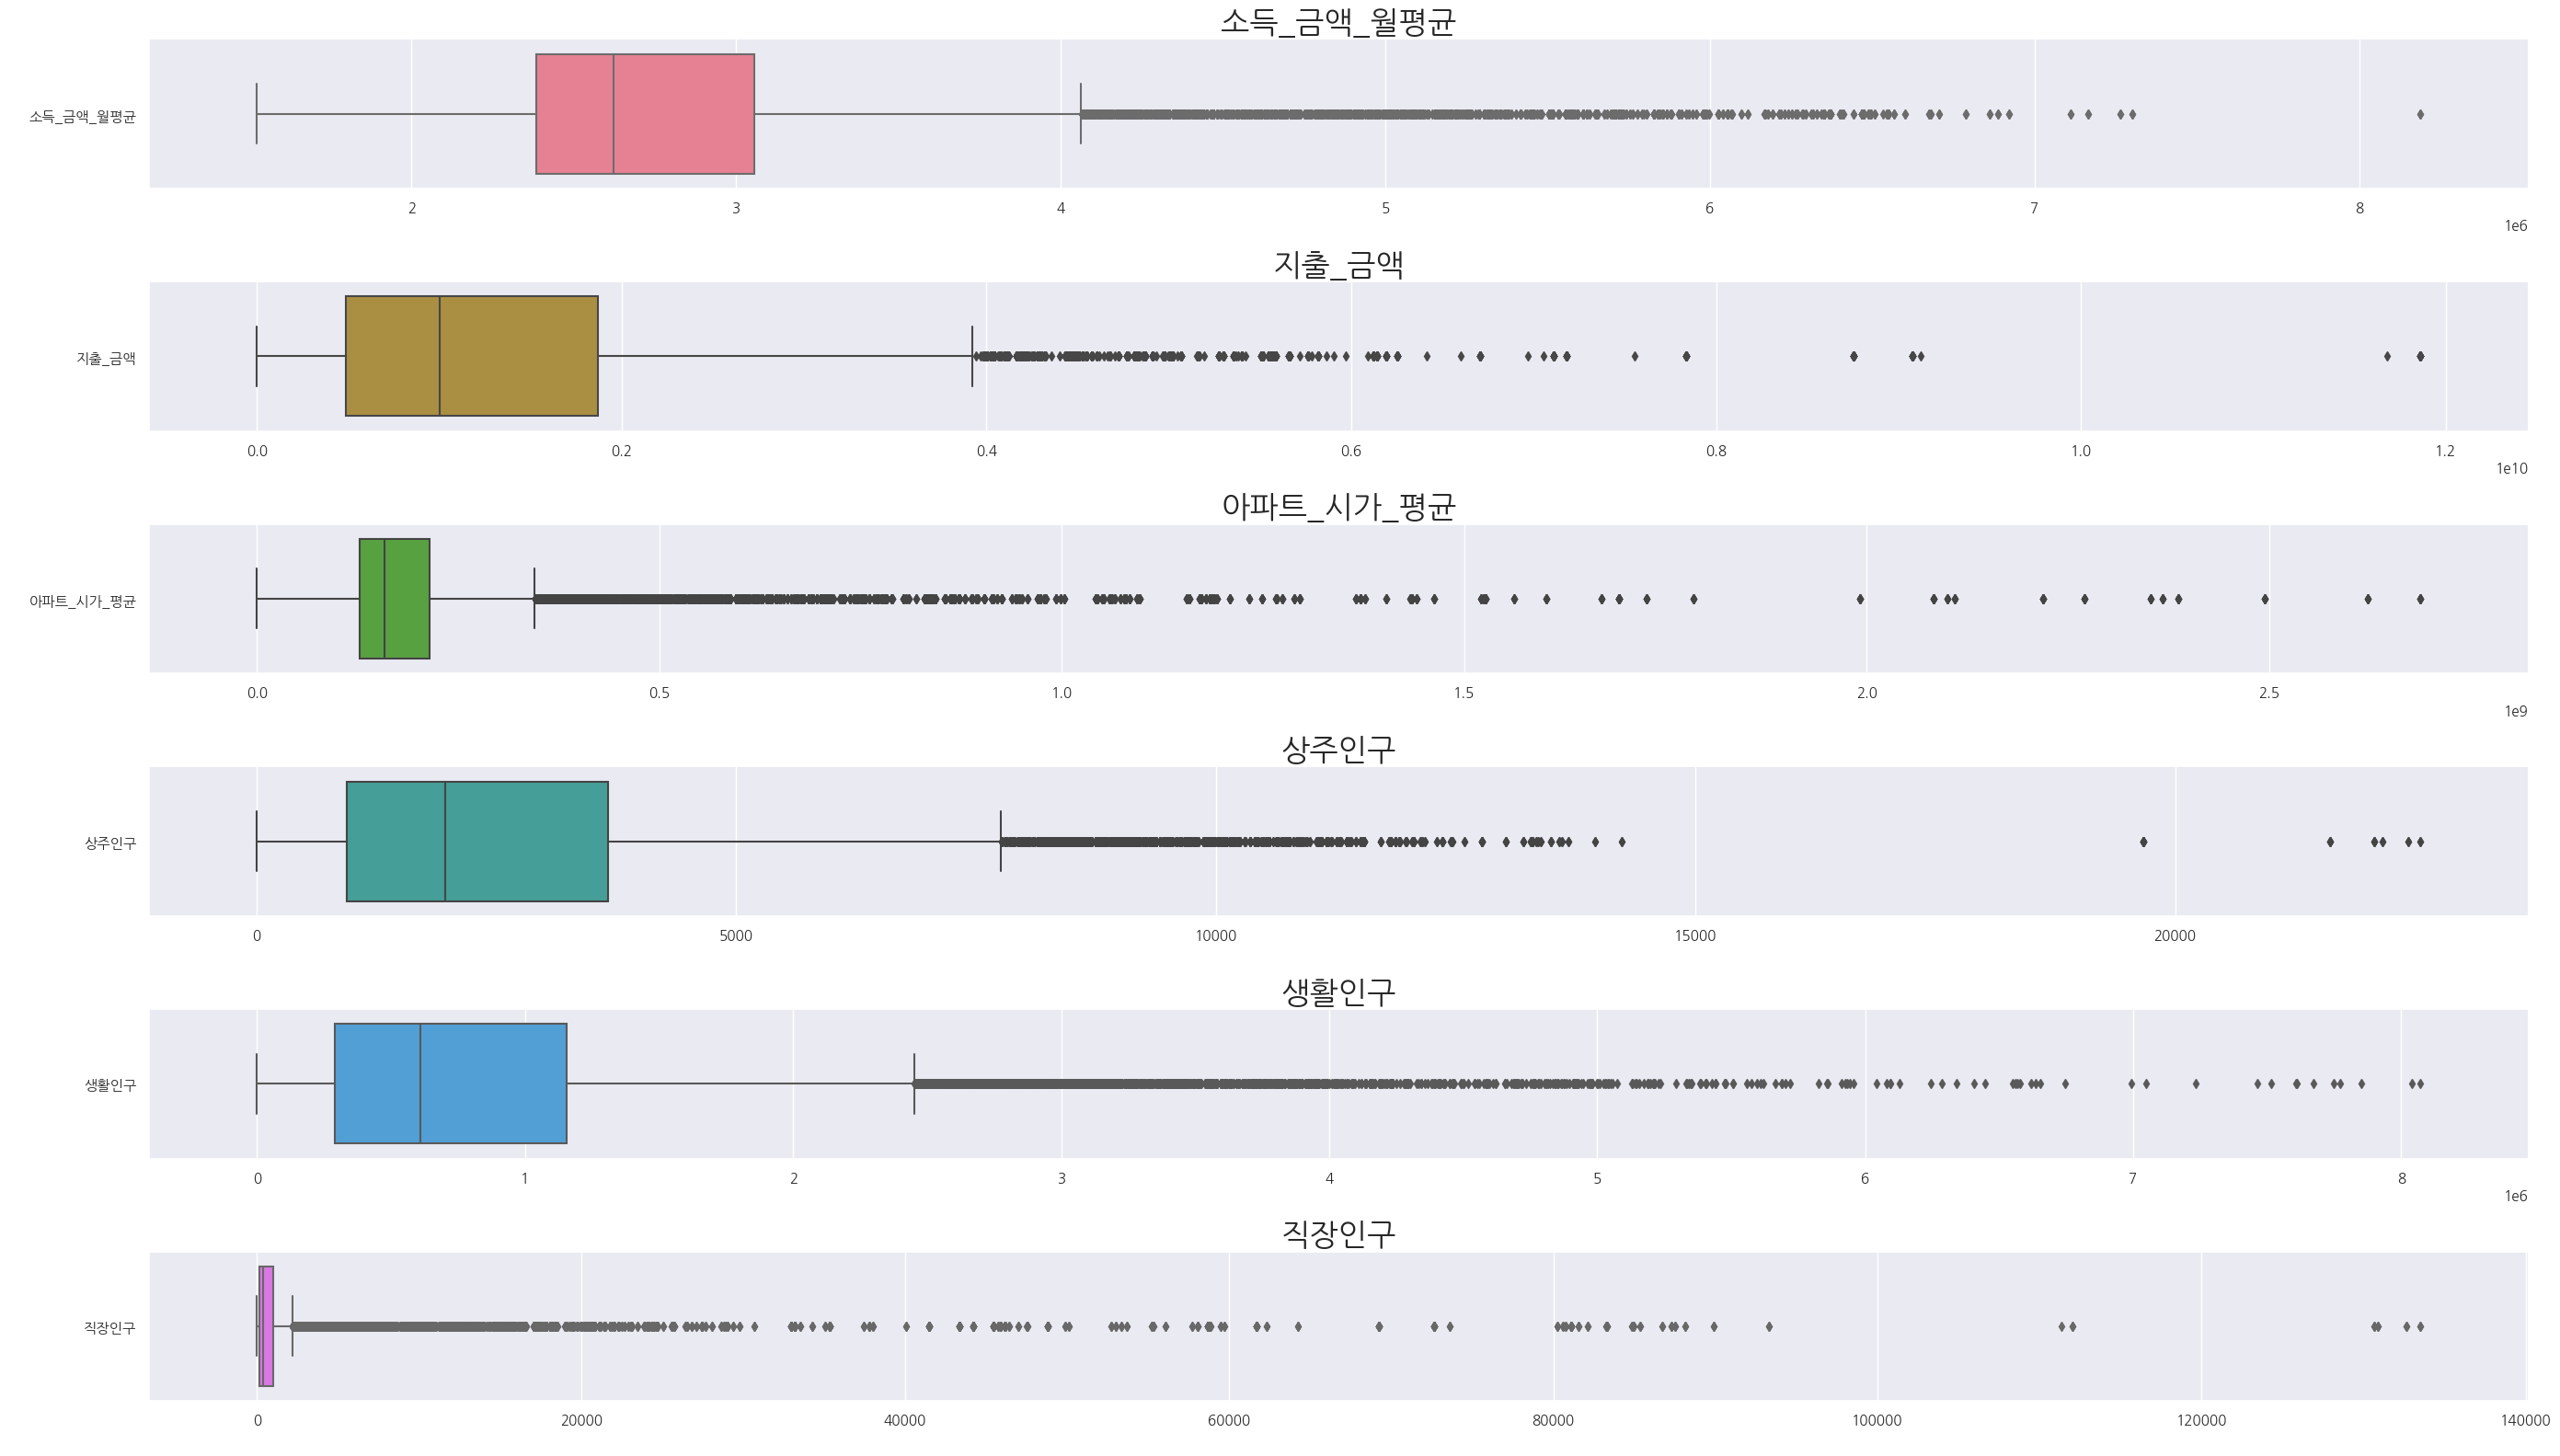

In [ ]:
df = pd.read_csv(data.PARSEDLIST[0])

palette = sns.color_palette("husl", len(variable.FEATURE))

fig = plt.figure(figsize = (28, 16))

for i in range(len(variable.FEATURE)):
    globals()[f"ax{i}"] = fig.add_subplot(6, 1, i+1)

    sns.set(
        font_scale = 1,
        font = "NanumGothic"
        )

    sns.boxplot(
        data = df[[variable.FEATURE[i]]].melt(),
        x = 'value',
        y = 'variable',
        palette=[palette[i]]
        )

    globals()[f"ax{i}"].set_title(
        f"{variable.FEATURE[i]}",
        fontsize = 24
        )
    globals()[f"ax{i}"].set_xlabel(' ')
    globals()[f"ax{i}"].set_ylabel(' ')

fig.tight_layout()

fig.show()

## 이상치 삭제 전후 관측치 차이 비교

In [ ]:
before_num = []
after_num = []

for i in range(len(data.PARSEDLIST)):
    df = pd.read_csv(data.PARSEDLIST[i])
    dfx = df[variable.FEATURE]

    q1 = dfx.quantile(0.25)
    q3 = dfx.quantile(0.75)
    IQR = q3 - q1

    c = dfx[(dfx < q1 - 1.5*IQR) | (dfx > q3 + 1.5*IQR)]
    dfx_robust = dfx[dfx != c].dropna()

    before_num.append(len(dfx))
    after_num.append(len(dfx_robust))

df_before = {
    "df":sector.NAMELIST,
    "num":before_num
    }
df_before = pd.DataFrame(df_before)
df_before['b/a'] = "before"

df_after = {
    "df":sector.NAMELIST,
    "num":after_num
    }
df_after = pd.DataFrame(df_after)
df_after['b/a'] = "after"

df_merge = pd.merge(df_before, df_after, how='outer')

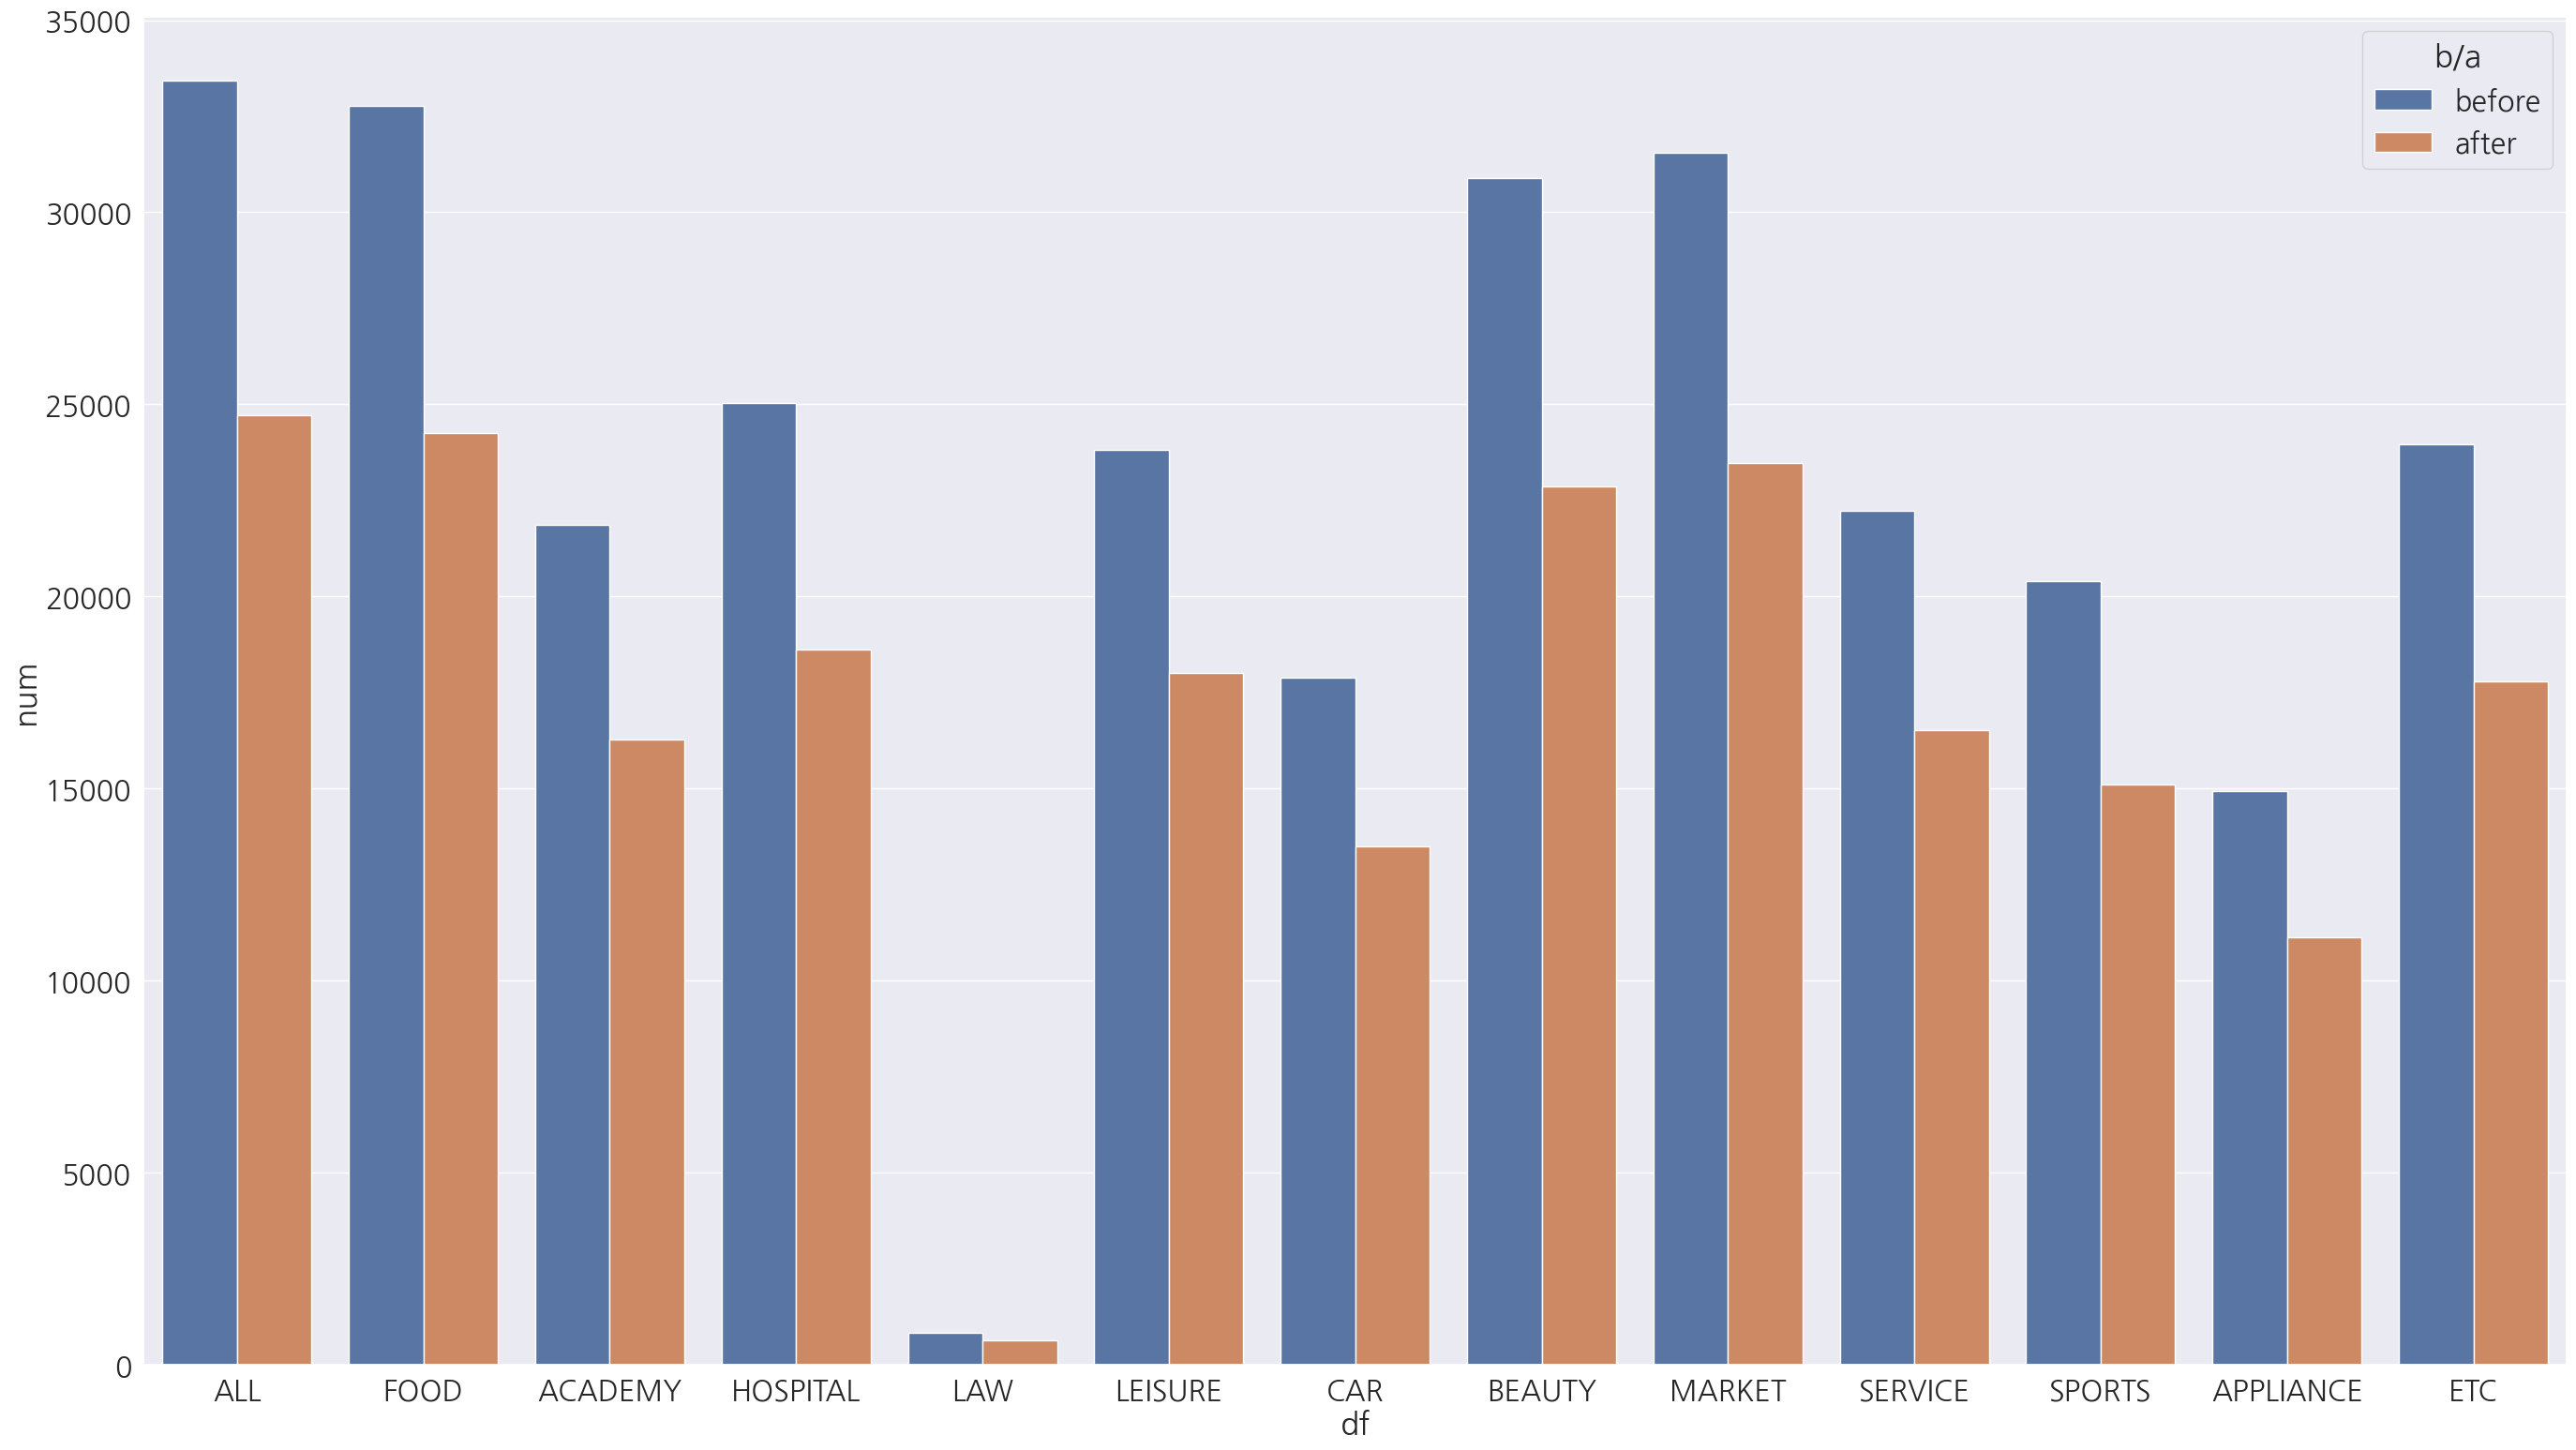

In [ ]:
fig = plt.figure(figsize = (28, 16))

sns.set(
    font_scale = 2,
    font = "NanumGothic"
    )

sns.barplot(
    x="df",
    y="num",
    data=df_merge,
    hue='b/a'
    )

fig.tight_layout()

fig.show()

# 정규화

## 표준화

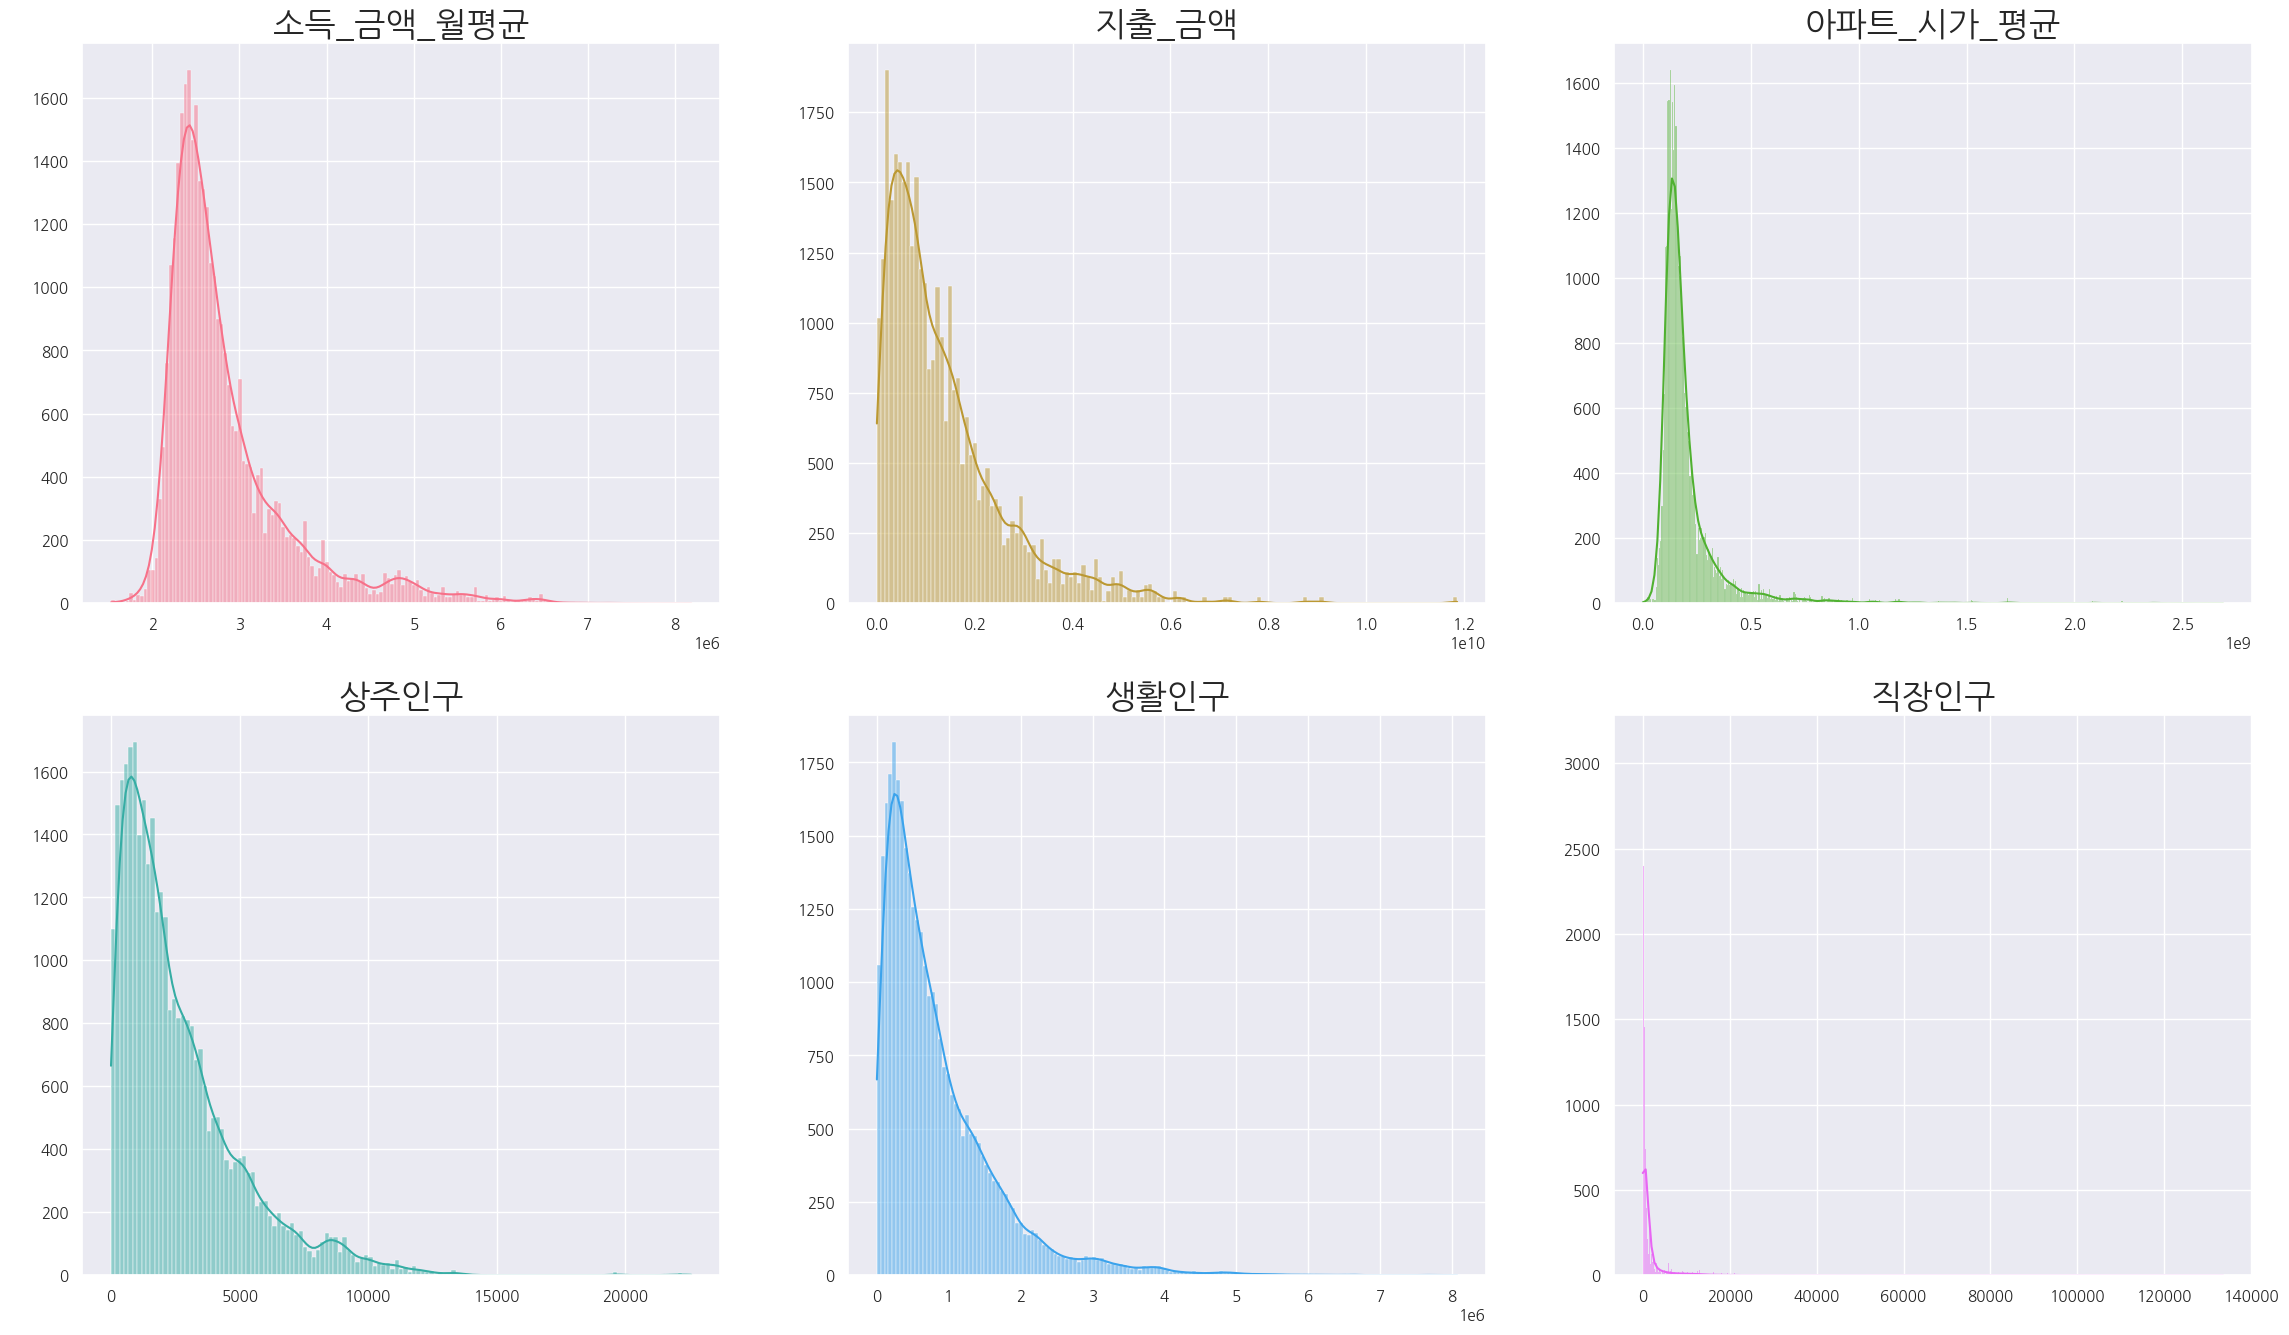

In [ ]:
df = pd.read_csv(data.PARSEDLIST[0])

palette = sns.color_palette("husl", len(variable.FEATURE))

fig = plt.figure(figsize = (28, 16))

for i in range(len(variable.FEATURE)):
    globals()[f"ax{i}"] = fig.add_subplot(2, 3, i+1)

    sns.set(
        font_scale = 1,
        font = "NanumGothic"
        )

    sns.histplot(
        df[variable.FEATURE[i]],
        kde=True,
        color=palette[i]
        )

    globals()[f"ax{i}"].set_xlabel(' ')
    globals()[f"ax{i}"].set_ylabel(' ')
    globals()[f"ax{i}"].set_title(
        f"{variable.FEATURE[i]}",
        fontsize = 24
        )

fig.tight_layout()

fig.show()

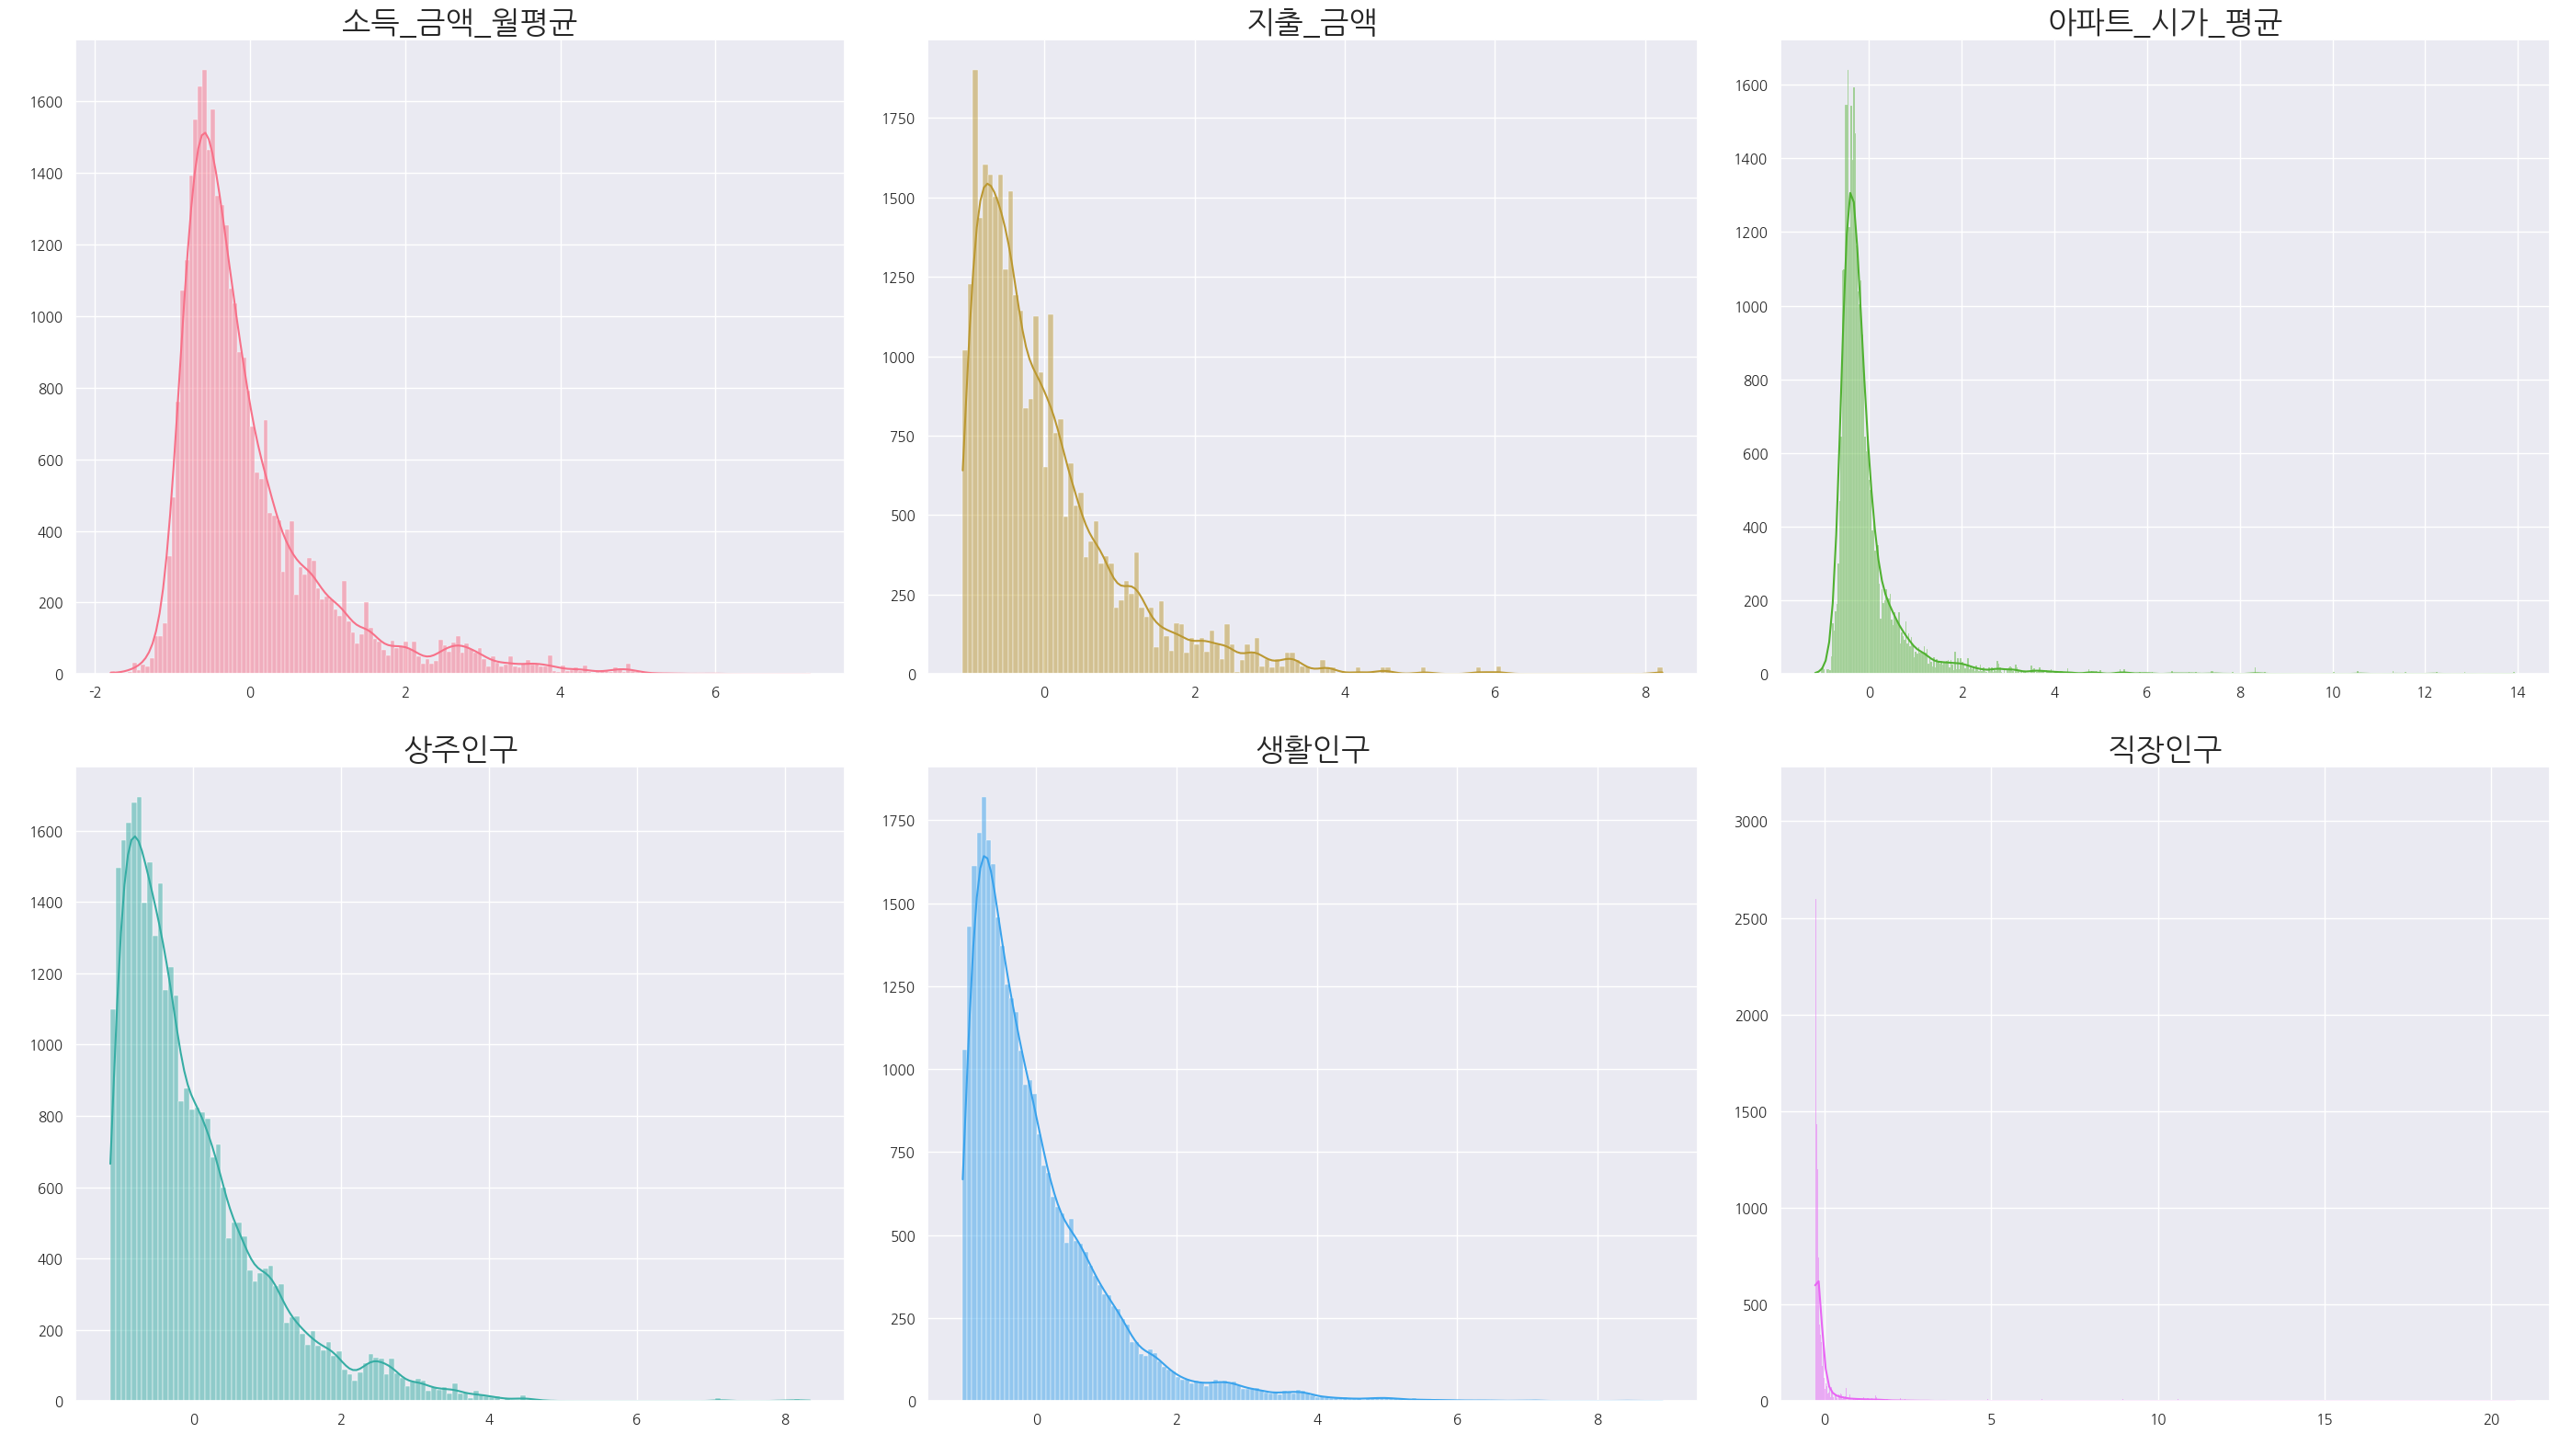

In [ ]:
scaler = StandardScaler()
df_standard = scaler.fit_transform(df[variable.FEATURE])
df_standard = pd.DataFrame(df_standard, columns = variable.FEATURE)

palette = sns.color_palette("husl", len(variable.FEATURE))

fig = plt.figure(figsize = (28, 16))

for i in range(len(variable.FEATURE)):
    globals()[f"ax{i}"] = fig.add_subplot(2, 3, i+1)

    sns.set(
        font_scale = 1,
        font = "NanumGothic"
        )

    sns.histplot(
        df_standard[variable.FEATURE[i]],
        kde=True,
        color=palette[i]
        )

    globals()[f"ax{i}"].set_xlabel(' ')
    globals()[f"ax{i}"].set_ylabel(' ')
    globals()[f"ax{i}"].set_title(
        f"{variable.FEATURE[i]}",
        fontsize = 24
        )

fig.tight_layout()

fig.show()

## 최대최소정규화

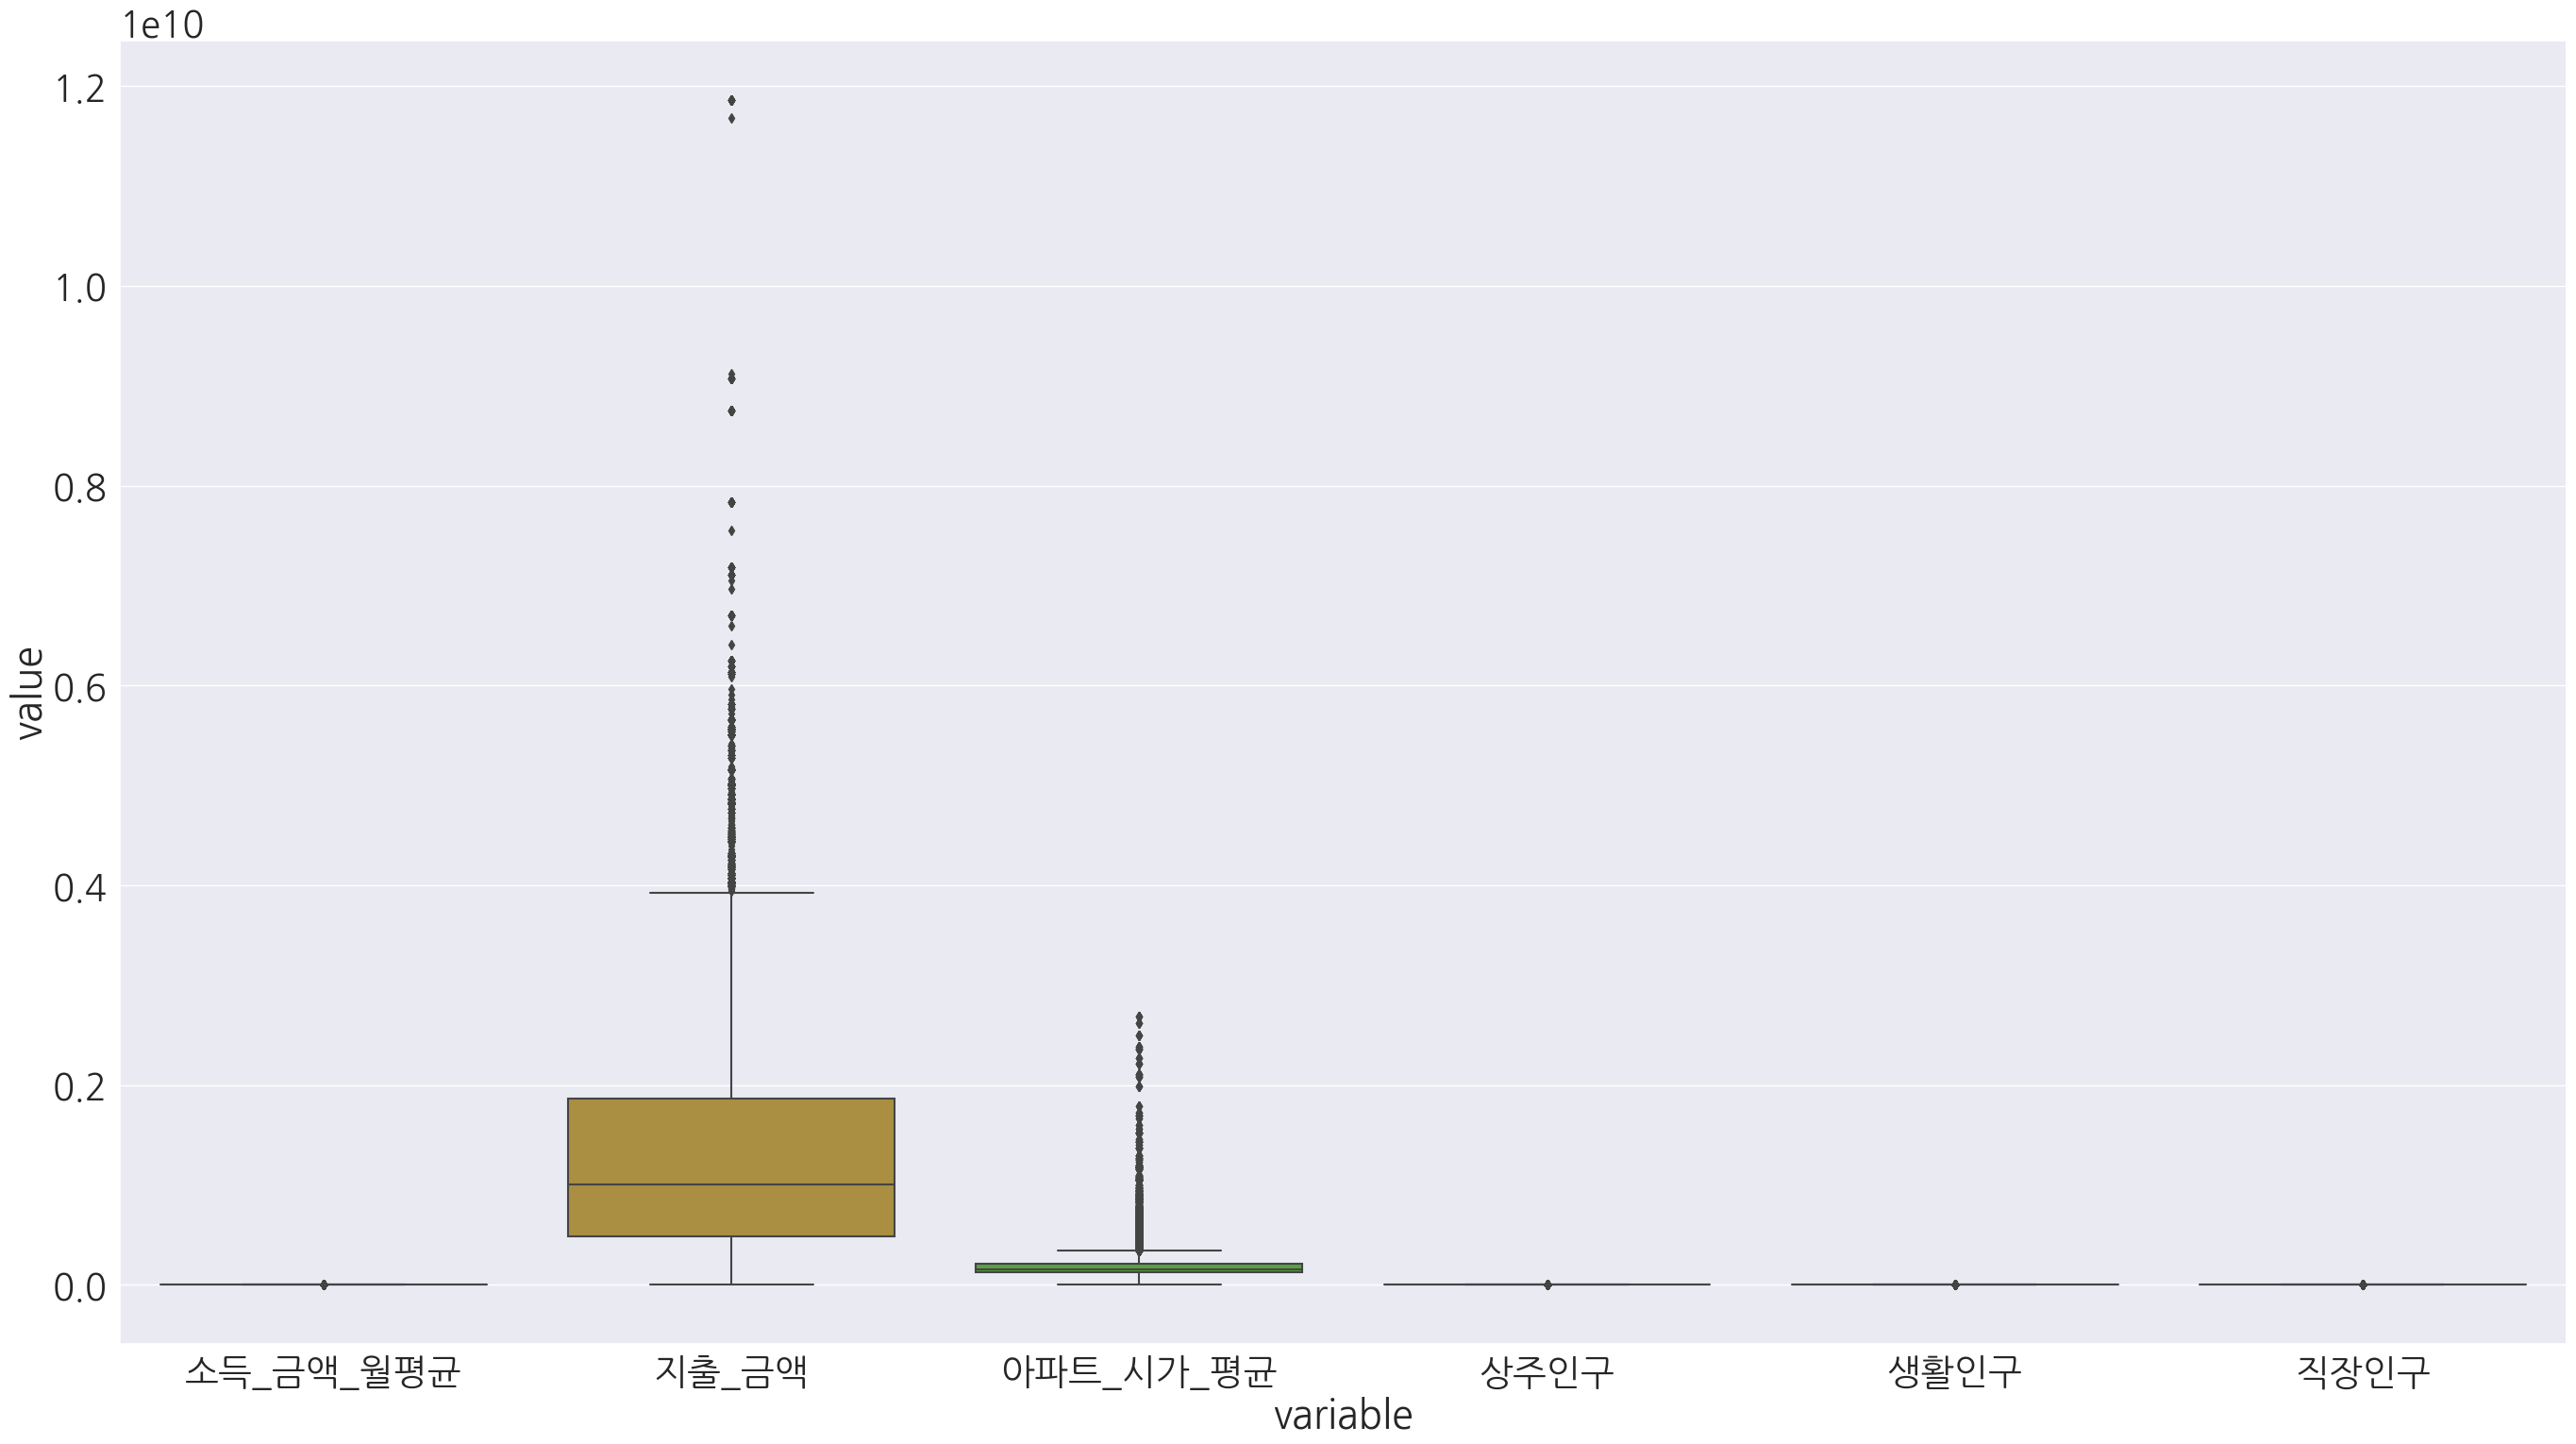

In [ ]:
palette = sns.color_palette("husl", len(variable.FEATURE))

fig = plt.figure(figsize = (28, 16))

sns.set(
    font_scale = 2.5,
    font = "NanumGothic"
    )

sns.boxplot(
    data = df[variable.FEATURE].melt(),
    x = 'variable',
    y = 'value',
    palette=palette
    )

fig.tight_layout()

fig.show()

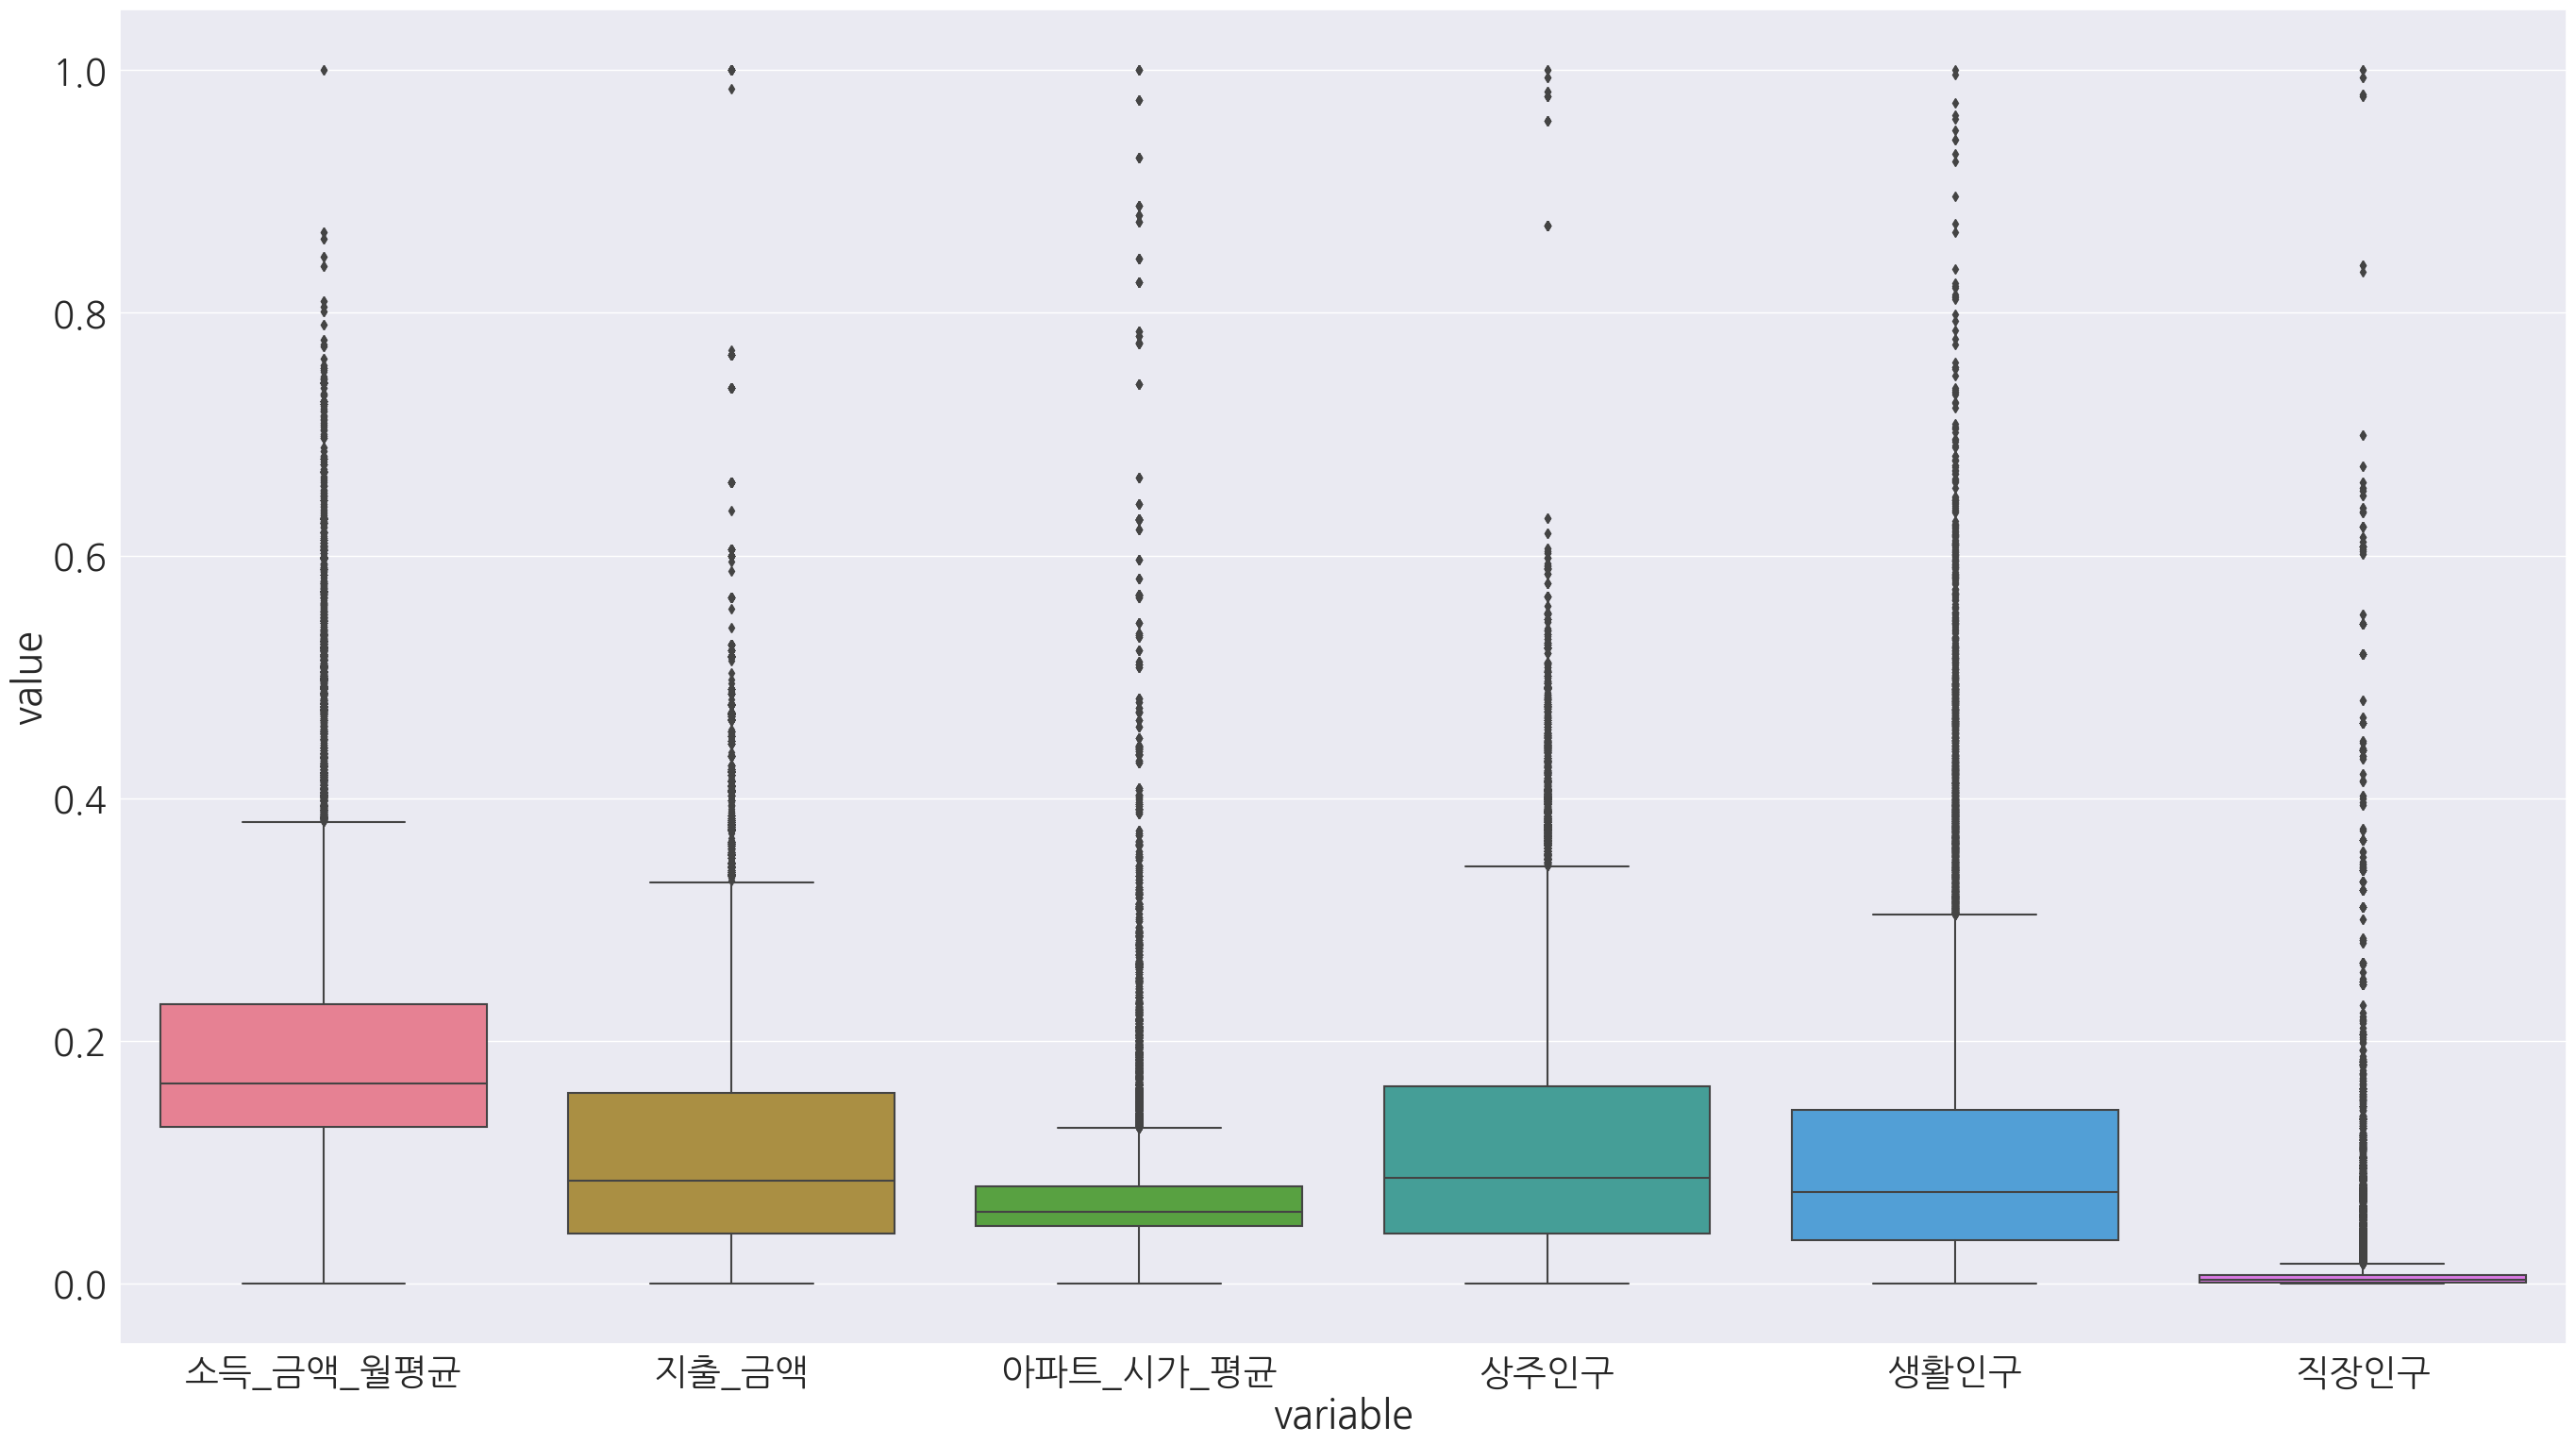

In [ ]:
scaler = MinMaxScaler()
df_minmax = scaler.fit_transform(df[variable.FEATURE])
df_minmax = pd.DataFrame(df_minmax, columns = variable.FEATURE)

palette = sns.color_palette("husl", len(variable.FEATURE))

fig = plt.figure(figsize = (28, 16))

sns.set(
    font_scale = 2.5,
    font = "NanumGothic"
    )

sns.boxplot(
    data = df_minmax.melt(),
    x = 'variable',
    y = 'value',
    palette=palette
    )

fig.tight_layout()

fig.show()